# Assignment 3 - Wine Quality Dataset

Dongbo Zhang

dzhang48@gatech.edu

In [38]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection as RP
from sklearn.ensemble import RandomForestClassifier

import time
from sklearn.manifold import TSNE

plt.style.use("ggplot")
# Set constant variables
RANDOM_SEED = 7
RANDOM_SEED_LIST = [7, 1987, 2020, 56, 787, 9876, 4812, 90, 88, 10]
N_FOLDS = 5
TEST_SIZE = 0.3

## Prepare Dataset

The dataset used in the analysis is the Wine Quality Dataset from UCI Machine Learning Repository.

Link to download the dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

Description of the dataset: https://archive.ics.uci.edu/ml/datasets/wine+quality

Reference: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [3]:
wine_data_red = pd.read_csv('winequality-red.csv', delimiter=';')
wine_data_red['red_wine'] = 1
wine_data_white = pd.read_csv('winequality-white.csv', delimiter=';')
wine_data_white['red_wine'] = 0
wine_data = pd.concat([wine_data_red,wine_data_white], axis=0)

### Preprocessing

In [4]:
# Drop NAs from the dataset
wine_data.dropna(inplace=True)
flag = wine_data['quality']
wine_data.drop('quality',inplace=True, axis=1)
wine_data['quality'] = flag

X = wine_data.iloc[:, :-1]
wine_data['quality_group'] = 0
wine_data.loc[(wine_data['quality']>5)&(wine_data['quality']<=7), 'quality_group'] = 1
wine_data.loc[wine_data['quality']>7, 'quality_group'] = 2
y = wine_data['quality_group'].values
#y = wine_data['quality'].values
features = X.columns
feature_transformer = Pipeline(steps = [('scaler', StandardScaler())])
preprocessing = ColumnTransformer(transformers=[('transformer', feature_transformer, features)])

# Standard Scaling
X[features] = preprocessing.fit_transform(X)    

## Part 1: Clustering
### K Means

Run K-Means using different number of clusters, validate the clustering quality, and determine the optimal number of clusters

In [5]:
from sklearn.metrics import silhouette_samples, silhouette_score

k_range = range(2,21)

def kmeans_iterate(k_range, X_features):
    res = {'k':[],
           'silhouette':[],
           'fit_time':[],
           'sse':[],
           }
    km_models = {}
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20)
        start_time = time.process_time()
        kmeans.fit(X_features)
        elapse = time.process_time() - start_time
        
        kmeans_labels = kmeans.predict(X_features)
        silhouette = silhouette_score(X_features, kmeans_labels)

        sse = kmeans.inertia_
        res['k'].append(k)
        res['silhouette'].append(silhouette)
        res['fit_time'].append(elapse)
        res['sse'].append(sse)
        km_models[k] = kmeans
        
    return res, km_models
        
kmeans_exp, km_models = kmeans_iterate(k_range, X)

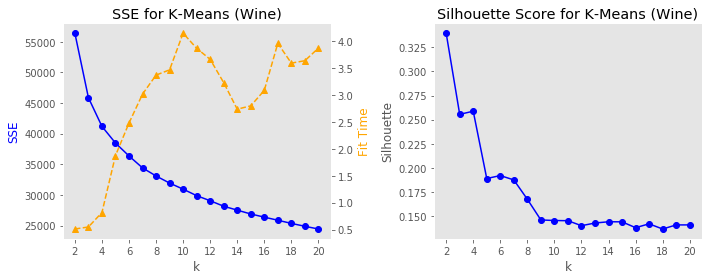

In [6]:
def plot_kmeans_internal_valid(exp_res, title, prefix='', dataset=''):
    """
    Use internal clustering criteria to validate K-means clustering
    with different numbers of clusters
    """
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(exp_res['k'], exp_res['sse'], marker='o', color='b')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('SSE', color='b')
    #ax[0].set_ylim([4000, 16000])
    ax[1].plot(exp_res['k'], exp_res['silhouette'], marker='o', color='b')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Silhouette')    
    ax[0].grid(False)
    ax[1].grid(False)
    ax[0].set_title('SSE for {} {}'.format(title, dataset))
    ax[1].set_title('Silhouette Score for {} {}'.format(title, dataset))
    
    
    ax2 = ax[0].twinx()
    ax2.set_ylabel('Fit Time', color='orange')
    ax2.grid(False)
    ax2.plot(exp_res['k'], exp_res['fit_time'], marker='^', linestyle='--', color='orange')
    
    ax[0].set_xticks(range(2, 22, 2))
    ax[1].set_xticks(range(2, 22, 2))

    plt.tight_layout()
    plt.savefig(prefix+'kmeans_internal_val.png', dpi=200)
    plt.show()
    
plot_kmeans_internal_valid(kmeans_exp, 'K-Means', prefix='wine_orig_', dataset='(Wine)')

### Use library YellowBrick to determine the elbow

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


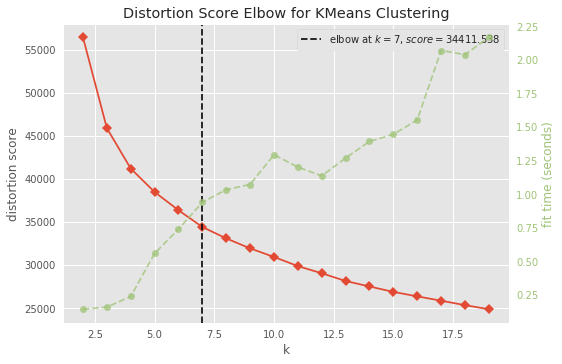

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


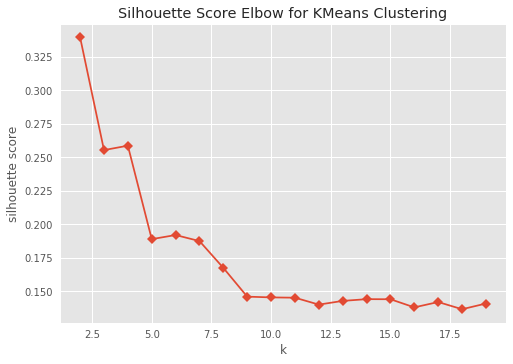

In [7]:
from yellowbrick.cluster import KElbowVisualizer
plt.style.use("ggplot")
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')
visualizer_sse.fit(X)       
visualizer_sse.show()       
visualizer_silhouette = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)
visualizer_silhouette.fit(X)       
visualizer_silhouette.show()

### Use Silhouette plots for analysis

For n_clusters = 2 The average silhouette_score is : 0.3395482826332112
For n_clusters = 3 The average silhouette_score is : 0.25546877121520795
For n_clusters = 4 The average silhouette_score is : 0.2587463861985061


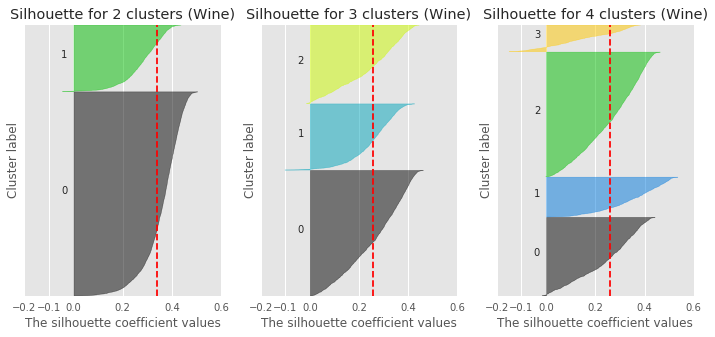

In [8]:
import matplotlib.cm as cm
def plot_silhouette(range_n_clusters, X, model, title='', dataset=''):
    """
    Below code is modified from Scikit Learn page:https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    
    
    """
    X = np.array(X)
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED) # first try without init='pca'
    X_tsne = tsne.fit_transform(X)
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    for k, n_clusters in enumerate(range_n_clusters):

        ax[k].set_xlim([-0.2, 0.6])
        ax[k].set_ylim([0, len(X) + (n_clusters + 1) * 10])
        if model == 'kmeans':
            clusterer = KMeans(random_state=RANDOM_SEED, n_init=20, n_clusters=n_clusters)
        elif model == 'gmm':
            clusterer = GaussianMixture(n_components=n_clusters,  n_init=20, random_state=RANDOM_SEED, covariance_type='full')
        
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
        
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax[k].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.5)

            # Label the silhouette plots with their cluster numbers at the middle
            ax[k].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax[k].set_title("Silhouette for {} clusters ({})".format(n_clusters, dataset))
        ax[k].set_xlabel("The silhouette coefficient values")
        ax[k].set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax[k].axvline(x=silhouette_avg, color="red", linestyle="--")

        ax[k].set_yticks([])  
        ax[k].set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6])
    plt.savefig(title+'silhouette_plot.png', dpi=200)
    plt.show()
    
plot_silhouette([2,3,4], X, 'kmeans', title='wine_orig_', dataset='Wine')

Use external evaluation to validate K-means clustering

In [9]:
from sklearn.metrics import homogeneity_score, completeness_score, normalized_mutual_info_score
from sklearn import metrics

def plot_eval_external(models, n_clusters_list, X, y):
    res_new = {'k':[],'homo_score':[], 'complete_score':[], 'v_score':[],'adj_rand_index':[],
          'adj_mutual_info':[], }
    for k in n_clusters_list:
        res_new['k'].append(k)
        optimal_kmeans = models[k]
        kmeans_labels_pred = optimal_kmeans.predict(X)
        res_new['homo_score'].append(homogeneity_score(y, kmeans_labels_pred))
        res_new['complete_score'].append(completeness_score(y, kmeans_labels_pred))
        res_new['v_score'].append(normalized_mutual_info_score(y, kmeans_labels_pred))
        res_new['adj_rand_index'].append(metrics.adjusted_rand_score(y, kmeans_labels_pred))
        res_new['adj_mutual_info'].append(metrics.adjusted_mutual_info_score(y, kmeans_labels_pred))
        
    return pd.DataFrame(res_new)
kmeans_external = plot_eval_external(km_models, [2, 3, 4, 8], X, y)
            
kmeans_external

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.011393,0.015925,0.013283,0.021987,0.013056
1,3,0.034306,0.025229,0.029076,0.038817,0.028750
2,4,0.042156,0.026766,0.032743,0.043228,0.032296
3,8,0.088422,0.035284,0.050440,0.028640,0.049679


### Choose the optimal number of clusters (k) = 3

Plot K-Means Clusters

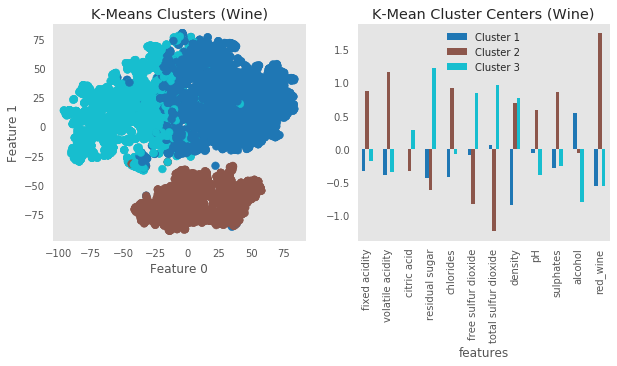

In [10]:
optimal_num_clusters = 3

def optimal_kmeans_analysis(X, optimal_num_clusters, save_fig=False, title='', dataset=''):
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED) # first try without init='pca'
    X_tsne = tsne.fit_transform(X)
          
    optimal_kmeans = KMeans(random_state=RANDOM_SEED, n_init=20, n_clusters=optimal_num_clusters)
    start_time = time.process_time()
    optimal_kmeans.fit(X)
    elapse = time.process_time() - start_time
    y_pred = optimal_kmeans.predict(X)


    cluster_centers = {'features': X.columns}
    for i in range(1, optimal_num_clusters+1):
        cluster_centers['Cluster '+ str(i)] = optimal_kmeans.cluster_centers_[i-1]
    optimal_kmeans_centers = pd.DataFrame(cluster_centers)
    optimal_kmeans_centers.set_index('features', inplace=True)


    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, s=60, cmap='tab10')
    ax[0].set_xlabel("Feature 0")
    ax[0].set_ylabel("Feature 1")
    ax[0].set_title('K-Means Clusters ({})'.format(dataset))
    optimal_kmeans_centers.plot(kind='bar', ax=ax[1], cmap='tab10')
    #ax[1].set_xticklabels(optimal_kmeans_centers.index, rotation=0)
    ax[1].set_title('K-Mean Cluster Centers ({})'.format(dataset))
    ax[0].grid(False)
    ax[1].grid(False)
    if save_fig:
        plt.savefig(title+'optimal_kmeans.png', dpi=200, bbox_inches = 'tight')
    plt.show()
    return optimal_kmeans, optimal_kmeans_centers, elapse
optimal_kmeans_orig, optimal_kmeans_orig_centers, optimal_kmeans_orig_fit_time = optimal_kmeans_analysis(X, optimal_num_clusters, save_fig=True, title='wine_orig_', dataset='Wine')

### Expectation Maximization (EM)

In [12]:
def em_iterate(k_range, X_features, cov_type):
    res = {'k':[], 
           'silhouette':[],
           'aic':[],
           'bic':[],
           'fit_time':[]}
    em_models = {}
    for k in k_range:
        print (k)
        em = GaussianMixture(n_components=k,  n_init=20, random_state=RANDOM_SEED, covariance_type=cov_type)
        start_time = time.process_time()
        em.fit(X_features)
        elapse = time.process_time() - start_time
        em_labels = em.predict(X_features)
        em_models[k] = em
        silhouette = silhouette_score(X_features, em_labels)
        
        aic = em.aic(X_features)
        bic = em.bic(X_features)
        res['k'].append(k)
        res['silhouette'].append(silhouette)
        res['aic'].append(aic)
        res['bic'].append(bic)
        res['fit_time'].append(elapse)
        
    return res, em_models
        
em_exp_full, em_models_full = em_iterate(k_range, X, 'full')
em_exp_tied, em_models_tied = em_iterate(k_range, X, 'tied')
em_exp_diag, em_models_diag = em_iterate(k_range, X, 'diag')
em_exp_sphe, em_models_sphe = em_iterate(k_range, X, 'spherical')

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


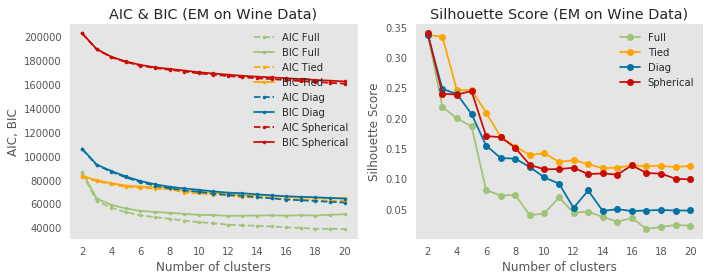

In [20]:
def plot_em_exp(exp_res, title, save_fig=False,prefix=""):
    colors = ['g','orange','b','r']
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    for i, k in enumerate(list(exp_res.keys())):
        ax[0].plot(exp_res[k]['k'], exp_res[k]['aic'], linestyle = '--', marker='.',  color=colors[i], label='AIC '+k)
        ax[0].plot(exp_res[k]['k'], exp_res[k]['bic'], color=colors[i], marker='.', label='BIC '+k)
        ax[1].plot(exp_res[k]['k'], exp_res[k]['silhouette'], marker='o', color=colors[i], label=k )
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('AIC, BIC')
    
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Score')
    ax[0].grid(False)
    ax[1].grid(False)
    ax[0].set_title('AIC & BIC ({})'.format(title))
    ax[1].set_title('Silhouette Score ({})'.format(title))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xticks(range(2, 22, 2))
    ax[1].set_xticks(range(2, 22, 2))
    
    #ax2 = ax[1].twinx() 
    #ax2.set_ylabel('Fit Time', color='orange')
    #ax2.plot(exp_res['k'], exp_res['fit_time'], marker='^', linestyle='--', color='orange')
    #ax2.grid(False)

    plt.tight_layout()
    if save_fig:
        plt.savefig(prefix+'em_internal_val.png', dpi=200)
    plt.show()
    
em_exp_all = {'Full':em_exp_full,'Tied':em_exp_tied,'Diag':em_exp_diag, 'Spherical':em_exp_sphe}
plot_em_exp(em_exp_all, 'EM on Wine Data', save_fig=True, prefix='wine_orig_')

For n_clusters = 3 The average silhouette_score is : 0.21783215801179084
For n_clusters = 4 The average silhouette_score is : 0.19912496460314166
For n_clusters = 5 The average silhouette_score is : 0.18589887124908866


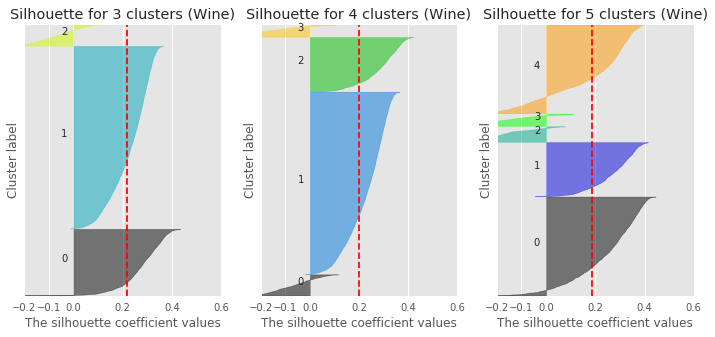

In [89]:
plot_silhouette([3, 4, 5], X, 'gmm', title='wine_orig_em_', dataset='Wine')

External Evaluation

In [58]:
em_external = plot_eval_external(em_models_full, [2, 3, 4, 5, 6, 8, 11], X, y)
            
em_external

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.010556,0.014741,0.012303,0.019841,0.012075
1,3,0.031475,0.030319,0.030886,0.051370,0.030509
2,4,0.031748,0.026702,0.029007,0.052108,0.028478
3,5,0.071694,0.041079,0.052231,0.058705,0.051682
4,6,0.044820,0.021672,0.029217,0.035691,0.028588
5,8,0.068400,0.027789,0.039521,0.023747,0.038748
6,11,0.096583,0.035416,0.051828,0.026065,0.050802


Plot GMM Clusters

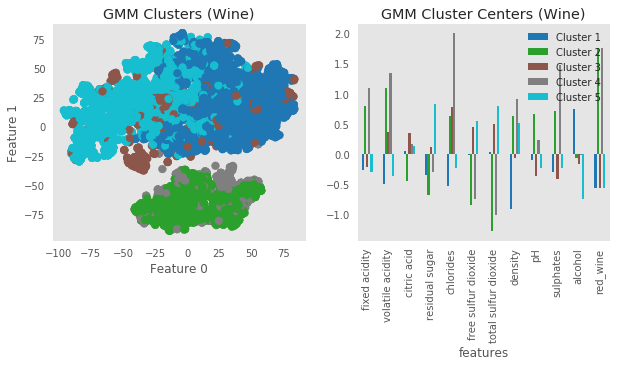

In [167]:
def optimal_gmm_analysis(X, optimal_num_clusters, save_fig=False, title='', dataset=''):
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED) # first try without init='pca'
    X_tsne = tsne.fit_transform(X)
          
    optimal_gmm = GaussianMixture(random_state=RANDOM_SEED,  n_components=optimal_num_clusters, n_init=20, covariance_type='full')


    start_time = time.process_time()
    optimal_gmm.fit(X)
    elapse = time.process_time() - start_time
    y_pred = optimal_gmm.predict(X)


    cluster_centers = {'features': X.columns}
    for i in range(1, optimal_num_clusters+1):
        cluster_centers['Cluster '+ str(i)] = optimal_gmm.means_[i-1]
    optimal_gmm_centers = pd.DataFrame(cluster_centers)
    optimal_gmm_centers.set_index('features', inplace=True)


    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, s=60, cmap='tab10')
    ax[0].set_xlabel("Feature 0")
    ax[0].set_ylabel("Feature 1")
    ax[0].set_title('GMM Clusters ({})'.format(dataset))
    optimal_gmm_centers.plot(kind='bar', ax=ax[1], cmap='tab10')
    #ax[1].set_xticklabels(optimal_kmeans_centers.index, rotation=0)
    ax[1].set_title('GMM Cluster Centers ({})'.format(dataset))
    ax[0].grid(False)
    ax[1].grid(False)
    if save_fig:
        plt.savefig(title+'optimal_gmm.png', dpi=100, bbox_inches = 'tight')
    plt.show()
    return optimal_gmm, optimal_gmm_centers, elapse

optimal_num_clusters_gmm = 5
optimal_gmm_orig, optimal_gmm_orig_centers, optimal_gmm_orig_fit_time = optimal_gmm_analysis(X, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='wine_orig_', dataset='Wine')

## Part 2: Dimension Reduction

### 2.1 Principal Component Analysis (PCA)

PCA tries to find a low-dimensional representation of the features while keeping as much information as possible.

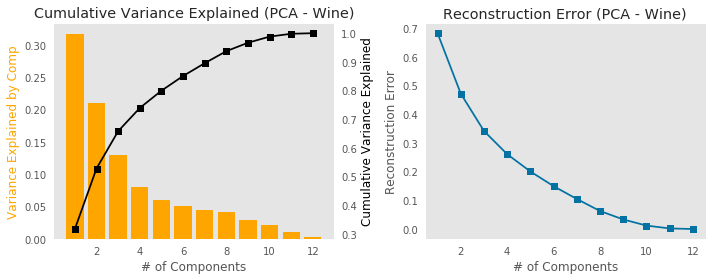

In [28]:
def pca_experiment(n_comp, X_features):
    
    
    pca = PCA(n_components=n_comp,
                  whiten=False, random_state=RANDOM_SEED).fit(X_features)
    X_features_PCA = pd.DataFrame(pca.transform(X_features))

    
    # Explained Variance
    
    explained_var_ratio =  pca.explained_variance_ratio_  
    sum_explained_var_ratio = np.cumsum(explained_var_ratio)
    
    # Reconstruction Error
    reconst_errors, pca_res = [], {}
    for k in range(1,n_comp+1):
        pca = PCA(n_components=k,
                  whiten=False, random_state=RANDOM_SEED).fit(X_features)
        X_features_PCA_ = pd.DataFrame(pca.transform(X_features))
        pca_res[k] = pca
        reconstruct_X_features = pd.DataFrame(pca.inverse_transform(X_features_PCA_))
        reconst_error = mean_squared_error(reconstruct_X_features, X_features)
        reconst_errors.append(reconst_error)
    
    res_metrics = {'n_principal_comp':list(range(1,n_comp+1)), 
           'Variance Explained by Comp': explained_var_ratio,
           'Cumulative Variance Explained':sum_explained_var_ratio,
           'Reconstruction Error': reconst_errors}
    
    return res_metrics, pca_res

X_pca_metrics, X_pca_res = pca_experiment(X.shape[1], X)
X_pca_metrics_df = pd.DataFrame(X_pca_metrics)

def plot_dim_reduct_exp(exp_res, title, fields=[], colors=['black','b','orange'], pca_col = []):
    if len(fields) > 0:
        fig, ax = plt.subplots(1, len(fields), figsize=(4*len(fields)+2,4))
        if len(fields) == 1:
            ax.plot(exp_res[exp_res.columns[0]], exp_res[fields[0]], marker='.', color=colors[0])
            ax.set_xlabel('# of Components')
            ax.set_ylabel('{}'.format(fields[0]))
            ax.grid(False)
            ax.set_title('{} ({})'.format(fields[0], title))
        else:
            if len(pca_col) > 0:
                ax[0].set_xlabel('# of Components')
                ax[0].set_ylabel('{}'.format(pca_col[0]), color=colors[-1])
                ax[0].grid(False)
                ax2 = ax[0].twinx() 
                
                ax2.set_ylabel('{}'.format(fields[0]),color=colors[0])

                ax2.grid(False)
                ax[0].bar(exp_res[exp_res.columns[0]], exp_res[pca_col[0]], color=colors[-1])
                
                ax2.plot(exp_res[exp_res.columns[0]], exp_res[fields[0]], marker='s', color=colors[0])
                
                ax[0].set_title('{} ({})'.format(fields[0], title))
            plot_range = range(1, len(fields)) if len(pca_col) > 0 else range(len(fields))
            for i in plot_range:
                ax[i].plot(exp_res[exp_res.columns[0]], exp_res[fields[i]], marker='s', color=colors[i])
                ax[i].set_xlabel('# of Components')
                ax[i].set_ylabel('{}'.format(fields[i]))
                ax[i].grid(False)
                ax[i].set_title('{} ({})'.format(fields[i], title))
        plt.tight_layout()
        plt.savefig('{}.png'.format(title), dpi=200)
        
        plt.show()
        
    
plot_dim_reduct_exp(X_pca_metrics_df, 
                    'PCA - Wine', ['Cumulative Variance Explained','Reconstruction Error'],
                    pca_col = ['Variance Explained by Comp']) 

Optimal # of dimension using PCA

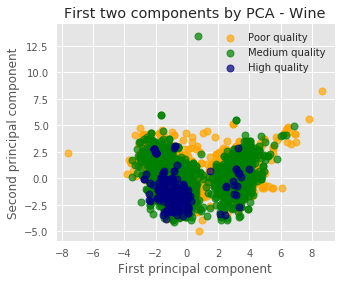

In [30]:
# Select number of principal components = 8
num_comp_PCA = 6
pca = PCA(n_components=num_comp_PCA,
                  whiten=False, random_state=RANDOM_SEED).fit(X)
X_features_PCA = pd.DataFrame(pca.transform(X))


def plot_dr(X_feature, y, title, filename):
    colors=['orange', 'green', 'blue']
    X_feature = np.array(X_feature)
    plt.figure(figsize=(5, 4))

    for color, i, target_name in zip(['orange', 'green', 'navy'], [0, 1, 2], ['Poor quality','Medium quality','High quality']):
        plt.scatter(X_feature[y == i, 0], X_feature[y == i, 1], color=color, alpha=.7, lw=1,
                label=target_name)  
    plt.legend()
    plt.title('First two components by {}'.format(title))
    if 'PCA' in title:
        plt.xlabel("First principal component")
        plt.ylabel("Second principal component")
    else:
        plt.xlabel("First component")
        plt.ylabel("Second component")
    plt.savefig(filename+'_visualization.png',dpi=200,bbox_inches = 'tight') 
    
plot_dr(X_features_PCA, y, 'PCA - Wine', 'WINE_PCA' ) 

### 2.2 Independent Component Aanalysis

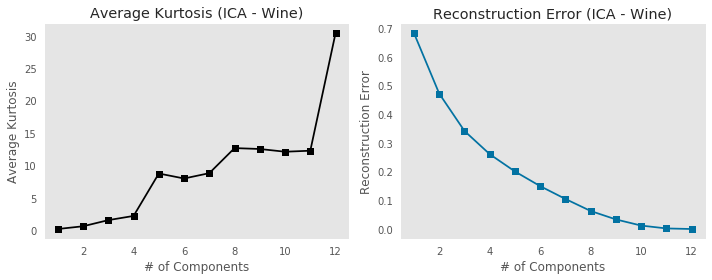

In [31]:
def ica_experiment(n_comp, X_features):
    kurtosis_list, reconst_errors, res_ica = [], [], {}
    for k in range(1, n_comp+1):
        ica = FastICA(n_components=k, max_iter = 500, random_state=RANDOM_SEED).fit(X_features)
        X_features_ICA = pd.DataFrame(ica.transform(X_features))
        res_ica[k] = ica
        
        # Kurtosis
        mean_kurtosis = X_features_ICA.kurtosis(axis=0).abs().mean()
        kurtosis_list.append(mean_kurtosis)
        
        # Reconstruction Error
    
        reconstruct_X_features = pd.DataFrame(ica.inverse_transform(X_features_ICA))
        
        reconst_error = mean_squared_error(reconstruct_X_features, X_features)
        reconst_errors.append(reconst_error)

    
    res_metrics = {'n_principal_comp':list(range(1,n_comp+1)), 
           'Average Kurtosis':kurtosis_list,
           'Reconstruction Error':reconst_errors}

    return res_metrics, res_ica



X_ica_metrics,  X_ica_res= ica_experiment(X.shape[1], X)
X_ica_metrics_df = pd.DataFrame(X_ica_metrics) 

plot_dim_reduct_exp(X_ica_metrics_df, 'ICA - Wine', ['Average Kurtosis','Reconstruction Error'])

Optimal # of dimensions: num_comp = 8

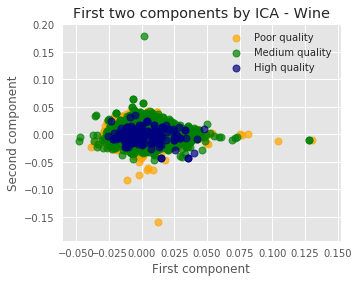

In [32]:
X_features_ICA = pd.DataFrame(X_ica_res[8].transform(X))

plot_dr(X_features_ICA, y, 'ICA - Wine',  'WINE_ICA' ) 

### 2.3 Random Projection

In [33]:
def rp_experiment(n_comp, X_features):
    res_list, model_list = [], []
    for seed in RANDOM_SEED_LIST:
        reconst_errors, res_rp = [], {}
        for k in range(1, n_comp+1):
            rp = RP(n_components=k,  random_state=seed).fit(X_features)
            X_features_RP = pd.DataFrame(rp.transform(X_features))
            res_rp[k] = rp
        
            # Reconstruction Error
            # The reconstruction of RP is using the same code from the inverse_transform function from ICA
            # https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_fastica.py#L604
            reconstruct_X_features = pd.DataFrame((X_features_RP.dot(np.linalg.pinv(rp.components_.T))))
            reconst_error = mean_squared_error(reconstruct_X_features, X_features)
            reconst_errors.append(reconst_error)
    
        res = {'n_comp':list(range(1,n_comp+1)), 
           'Reconstruction Error':reconst_errors}
        res_list.append(pd.DataFrame(res))
        model_list.append(res_rp)
    
    return res_list, model_list



X_rp_metrics, X_rp_res = rp_experiment(X.shape[1], X)

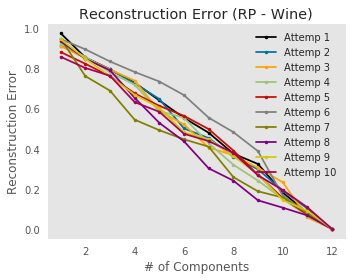

In [34]:
def plot_dim_reduct_exp_RP(exp_res, title, fields=[], colors=['black','b','orange','g', 'r', 
                                                              'gray','olive','purple', 'y','m']):
    if len(fields) > 0:
        fig, ax = plt.subplots(1, len(fields), figsize=(4*len(fields)+1,4))
        for i, res in enumerate(exp_res):
            ax.plot(res[res.columns[0]], res[fields[0]], marker='.', color=colors[i], label='Attemp {}'.format(i+1))
        ax.legend()
        ax.set_xlabel('# of Components')
        ax.set_ylabel('{}'.format(fields[0]))
        ax.grid(False)
        ax.set_title('{} ({})'.format(fields[0], title))

        plt.tight_layout()
        plt.savefig('{}.png'.format(title), dpi=200)
        
        plt.show()
        
plot_dim_reduct_exp_RP(X_rp_metrics, 'RP - Wine', fields=['Reconstruction Error'])

Given that the components by PCA and ICA all result in reconstruction error <= 0.2, we set a threhold of reconstruction error <= 0.2 for RP as well. We use a voting approach to select the # of components in the five runs.

In [35]:
comp_nums={}
for metrics_df in X_rp_metrics:
    comp_num=metrics_df[metrics_df['Reconstruction Error'] <= 0.2]['n_comp'].min()
    if comp_num not in comp_nums:
        comp_nums[comp_num] = 0
    else:
        comp_nums[comp_num] += 1
    
comp_nums

{10: 6, 11: 0, 9: 1}

Select the number of components = 11

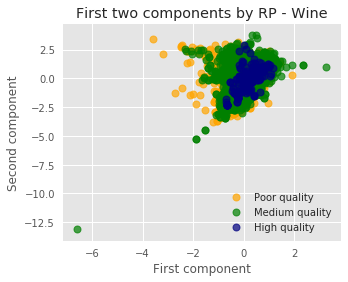

In [36]:
num_comp_RP= 10
rp = RP(n_components=num_comp_RP,  random_state=RANDOM_SEED).fit(X)
            
X_features_RP = pd.DataFrame(rp.transform(X))


plot_dr(X_features_RP, y, 'RP - Wine', 'Wine_RP') 

### 2.4 Random Forest (RF)

In [ ]:
param_grid = {
 'n_estimators': [200, 500], 
 'min_samples_leaf':[1, 2, 4],
 'min_samples_split': [2, 5, 10],
 }
# 'max_features':['auto','sqrt'], 'min_samples_leaf':[1, 2, 4]
rfc = RandomForestClassifier(random_state=RANDOM_SEED)
# Use function GridSearchCV 
grid = GridSearchCV(estimator=rfc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'accuracy', verbose=3)
grid.fit(X, y) 

# Find best model parameters
print ("Best Model Parameters:", grid.best_params_)

In [39]:
rfc = RandomForestClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=2, random_state=RANDOM_SEED)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

Calculate Feature Importance

In [40]:
features_importance = pd.DataFrame({'Feature Importance':rfc.feature_importances_, 'Feature':X.columns})
features_importance.sort_values('Feature Importance', ascending=False, inplace=True)
features_importance['Cumulative Importance'] = features_importance['Feature Importance'].cumsum()
#features_importance
#features_importance.set_index('Feature', inplace=True)

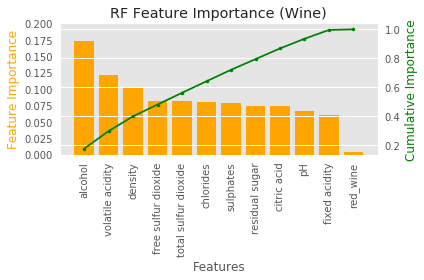

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.bar(features_importance['Feature'], features_importance['Feature Importance'], color='orange')
ax.set_xlabel('Features')
ax.set_ylabel('{}'.format('Feature Importance'), color='orange')
ax.grid(None)
ax.set_xticklabels(features_importance['Feature'], rotation=90)
ax2 = ax.twinx() 
                
ax2.set_ylabel('{}'.format('Cumulative Importance'),color='green')

len_ticks = max(len(ax.get_yticks()), len(ax2.get_yticks()))
larger_axis = ax if len(ax.get_yticks()) > len(ax2.get_yticks()) else ax2
larger_axis.set_yticks(np.linspace(larger_axis.get_yticks()[0], 
                                           larger_axis.get_yticks()[-1], 
                                           len_ticks))
ax2.plot(features_importance['Feature'], features_importance['Cumulative Importance'], 
         marker='.', color='green')
plt.title('RF Feature Importance (Wine)')
plt.tight_layout()
plt.savefig('Wine_rf.png', dpi=200)
plt.show()

(6497, 6)


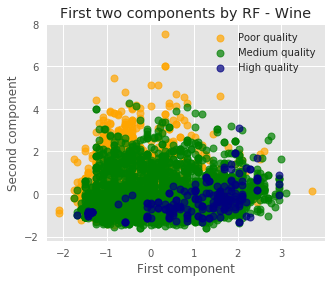

In [60]:
X_features_RF = X[features_importance.head(int(features_importance.shape[0]/2))['Feature'].tolist()]
print (X_features_RF.shape)
plot_dr(X_features_RF, y, 'RF - Wine', 'Wine_RF') 


### Comparison

ICA
RP
PCA


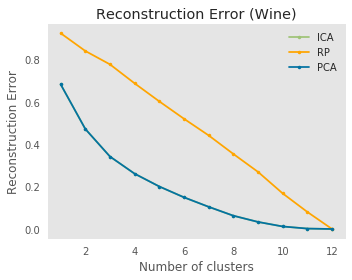

In [163]:


def plot_dr_comparison(exp_res, title, save_fig=False,prefix=""):
    colors = ['g','orange','b','r']
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    for i, k in enumerate(list(exp_res.keys())):
        print (k)
        ax.plot(exp_res[k].iloc[:,0], exp_res[k]['Reconstruction Error'],  marker='.',  color=colors[i], label=k)
    
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Reconstruction Error')
    ax.grid(False)
    ax.set_title('Reconstruction Error ({})'.format(title))
    ax.legend()
    plt.tight_layout()
    if save_fig:
        plt.savefig(prefix+'recon_error_all.png', dpi=100)
    plt.show()
    
dr_exp_all = {'ICA':X_ica_metrics_df,'RP':pd.DataFrame({'n_comp':X_rp_metrics[0].iloc[:, 0],
              'Reconstruction Error': np.array([np.array(X_rp_metrics[i].iloc[:, -1]) for i in range(len(X_rp_metrics))]).mean(axis=0)})

,'PCA':X_pca_metrics_df,}
plot_dr_comparison(dr_exp_all,'Wine', save_fig=True, prefix='wine_')

## Part 3: Dimension Reduction + Clustering

### 3.1 PCA & Clustering

3.1.1 PCA & K-Means Clustering

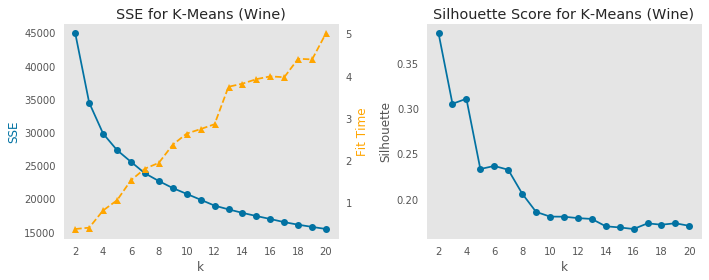

In [43]:
kmeans_exp_pca, km_models_pca = kmeans_iterate(k_range, X_features_PCA)

plot_kmeans_internal_valid(kmeans_exp_pca, 'PCA & K-Means', prefix='wine_PCA_', dataset='(Wine)')

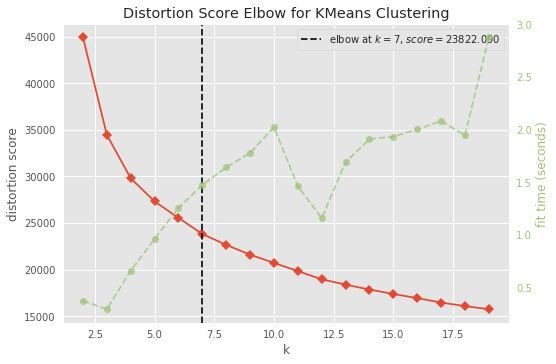

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


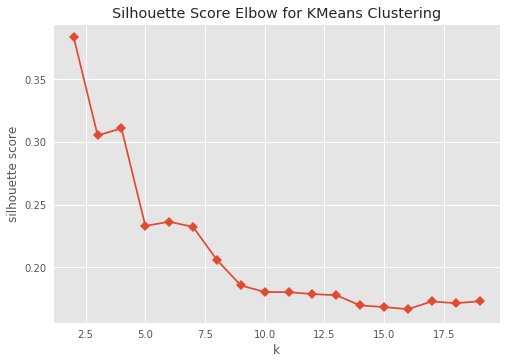

In [44]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')

visualizer_sse.fit(X_features_PCA)       
visualizer_sse.show()       


visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)

visualizer.fit(X_features_PCA)       
visualizer.show()

For n_clusters = 2 The average silhouette_score is : 0.38325058719827143
For n_clusters = 3 The average silhouette_score is : 0.3051776827061943
For n_clusters = 7 The average silhouette_score is : 0.2322424014238629


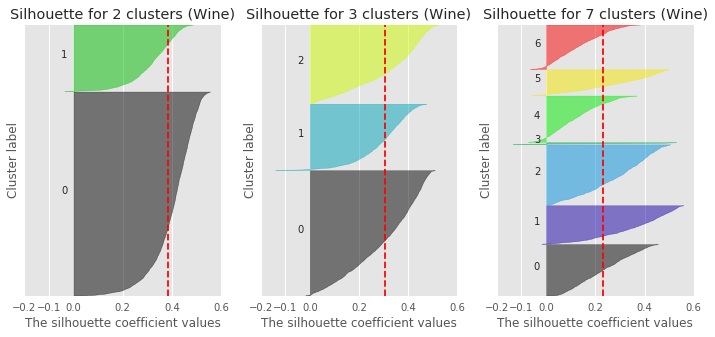

In [45]:
plot_silhouette([2,3,7], X_features_PCA, 'kmeans', title='wine_o_pca_', dataset='Wine')

In [46]:
kmeans_external_pca = plot_eval_external(km_models_pca, [2, 3, 7, 8], X_features_PCA, y)
            
kmeans_external_pca

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.011628,0.016228,0.013548,0.022451,0.013321
1,3,0.035120,0.025817,0.029758,0.038868,0.029433
2,7,0.081944,0.035703,0.049736,0.029954,0.049040
3,8,0.080289,0.031985,0.045746,0.026948,0.044982


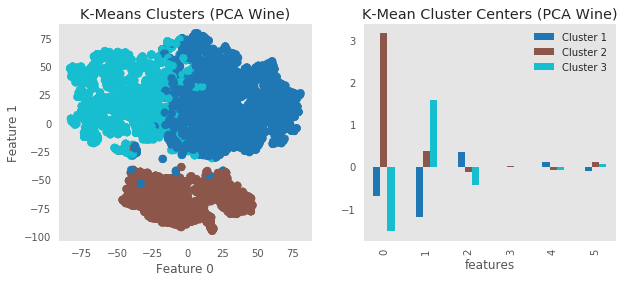

In [86]:
optimal_num_clusters = 3

optimal_kmeans_pca, optimal_kmeans_pca_centers, optimal_kmeans_pca_fit_time = optimal_kmeans_analysis(X_features_PCA, optimal_num_clusters, save_fig=True, title='wine_pca_', dataset='PCA Wine')

In [78]:
print (optimal_kmeans_pca_fit_time)
print (optimal_kmeans_orig_fit_time)

0.836211557999377
0.6674688310000079


3.1.2 PCA & EM Clustering

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


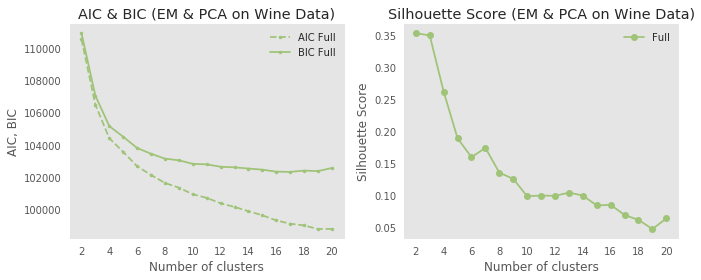

In [97]:
em_exp_full_pca, em_models_full_pca = em_iterate(k_range, X_features_PCA, 'full')
em_exp_all_pca = {'Full':em_exp_full_pca}
plot_em_exp(em_exp_all_pca, 'EM & PCA on Wine Data', save_fig=True, prefix='wine_pca_')  

In [100]:
em_external_pca = plot_eval_external(em_models_full_pca, [2, 3, 4, 5, 6, 7, 8, 11], X_features_PCA, y)          
em_external_pca

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.018521,0.024289,0.021017,0.032964,0.020797
1,3,0.020480,0.021688,0.021067,0.033099,0.020666
2,4,0.064857,0.040945,0.050199,0.062363,0.049761
3,5,0.049825,0.025881,0.034066,0.035235,0.033542
4,6,0.070462,0.032819,0.044780,0.038218,0.044178
5,7,0.092929,0.040797,0.056701,0.041347,0.056014
6,8,0.086341,0.036409,0.051220,0.037684,0.050435
7,11,0.083374,0.028919,0.042943,0.027389,0.041959


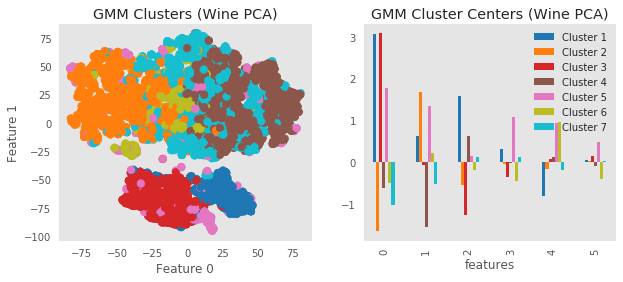

In [107]:
optimal_num_clusters_gmm = 7
optimal_gmm_pca, optimal_gmm_pca_centers, optimal_gmm_pca_fit_time = optimal_gmm_analysis(X_features_PCA, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='wine_pca_', dataset='Wine PCA')

### 3.2 ICA & Clustering

3.2.1 ICA & K-Means Clustering

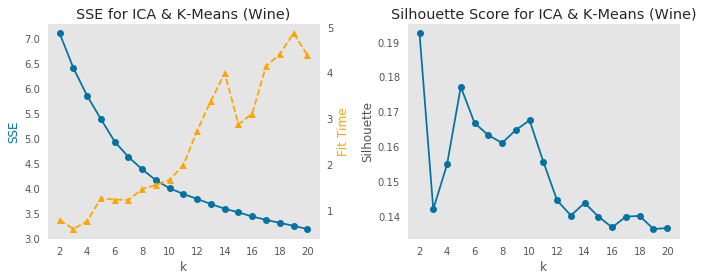

In [63]:
kmeans_exp_ica, km_models_ica = kmeans_iterate(k_range, X_features_ICA)

plot_kmeans_internal_valid(kmeans_exp_ica, 'ICA & K-Means', prefix='wine_ICA_', dataset='(Wine)')

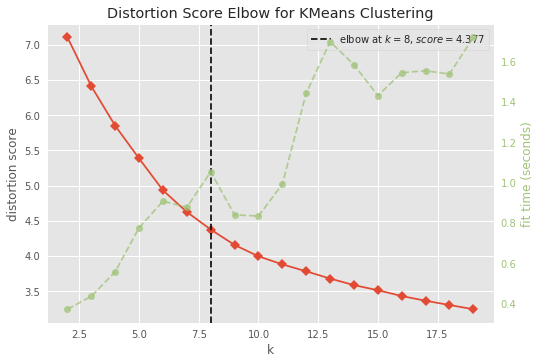

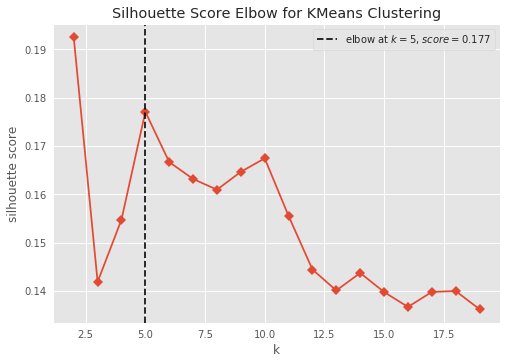

In [64]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')

visualizer_sse.fit(X_features_ICA)       
visualizer_sse.show()       


visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)

visualizer.fit(X_features_ICA)       
visualizer.show()

For n_clusters = 3 The average silhouette_score is : 0.14186742987918907
For n_clusters = 4 The average silhouette_score is : 0.15475807702530087
For n_clusters = 5 The average silhouette_score is : 0.17707438287166413


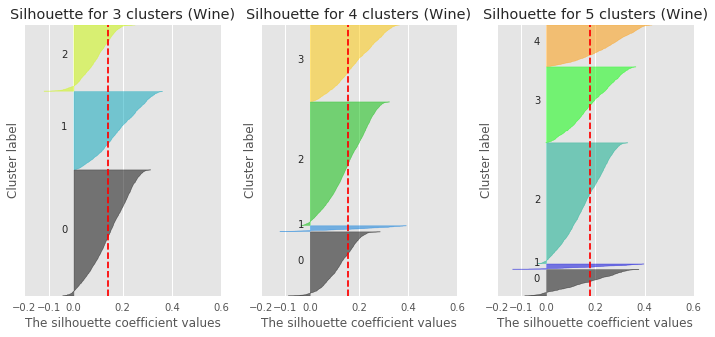

In [65]:
plot_silhouette([3,4,5], X_features_ICA, 'kmeans', title='wine_ica_', dataset='Wine')       

In [66]:
kmeans_external_ica = plot_eval_external(km_models_ica, [2, 3, 4, 5, 10], X_features_ICA, y)
            
kmeans_external_ica

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.011220,0.015687,0.013083,0.021582,0.012855
1,3,0.028185,0.020747,0.023900,0.033469,0.023573
2,4,0.030537,0.020926,0.024834,0.034573,0.024358
3,5,0.048682,0.029000,0.036347,0.045536,0.035772
4,10,0.097649,0.036082,0.052694,0.024777,0.051771


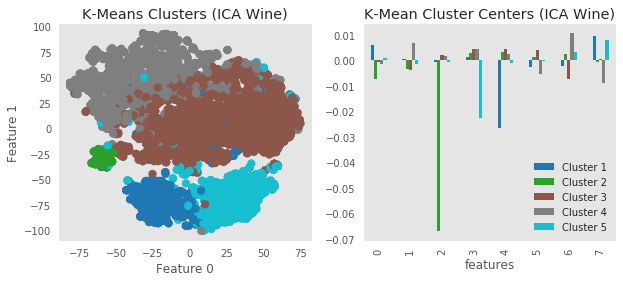

In [85]:
optimal_num_clusters = 5

optimal_kmeans_ica, optimal_kmeans_ica_centers, optimal_kmeans_ica_fit_time = optimal_kmeans_analysis(X_features_ICA, optimal_num_clusters, save_fig=True, title='wine_ica_', dataset='ICA Wine')

3.2.1 ICA & EM Clustering

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


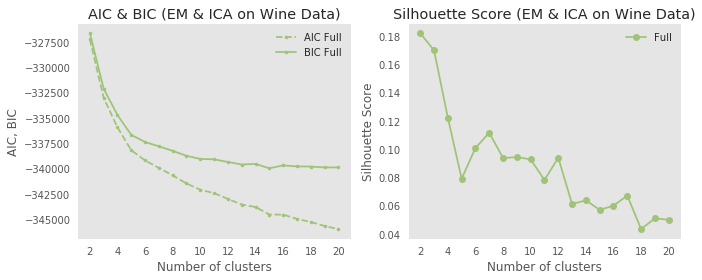

In [103]:
em_exp_full_ica, em_models_full_ica = em_iterate(k_range, X_features_ICA, 'full')
em_exp_all_ica = {'Full':em_exp_full_ica}
plot_em_exp(em_exp_all_ica, 'EM & ICA on Wine Data', save_fig=True, prefix='wine_ica_')  

In [104]:
em_external_ica = plot_eval_external(em_models_full_ica, [2, 3, 4, 5, 6, 7, 8, 11], X_features_ICA, y)          
em_external_ica

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.018212,0.023697,0.020596,0.033179,0.020376
1,3,0.022302,0.023002,0.022646,0.037271,0.022252
2,4,0.063916,0.039988,0.049197,0.058267,0.048762
3,5,0.068029,0.034551,0.045827,0.036104,0.045317
4,6,0.061818,0.030131,0.040515,0.024081,0.039889
5,7,0.082077,0.035751,0.049807,0.032570,0.049119
6,8,0.088214,0.035461,0.050586,0.029023,0.049829
7,11,0.113037,0.039013,0.058006,0.033609,0.057042


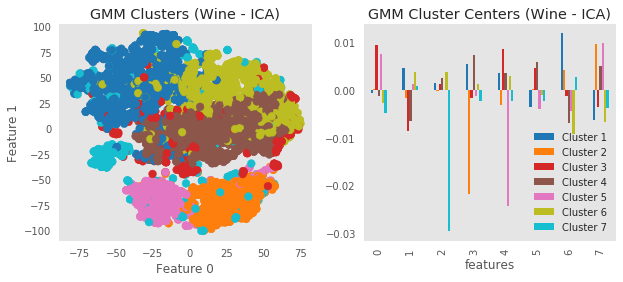

In [108]:
optimal_num_clusters_gmm = 7
optimal_gmm_ica, optimal_gmm_ica_centers, optimal_gmm_ica_fit_time = optimal_gmm_analysis(X_features_ICA, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='wine_ica_', dataset='Wine - ICA')

### 3.3 RP & Clustering

3.3.1 RP & K-Means Clustering

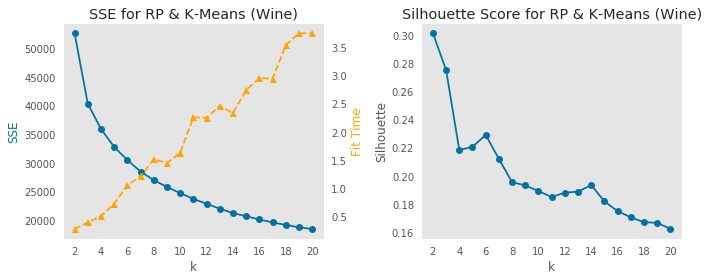

In [80]:
kmeans_exp_rp, km_models_rp = kmeans_iterate(k_range, X_features_RP)

plot_kmeans_internal_valid(kmeans_exp_rp, 'RP & K-Means', prefix='wine_RP_', dataset='(Wine)')

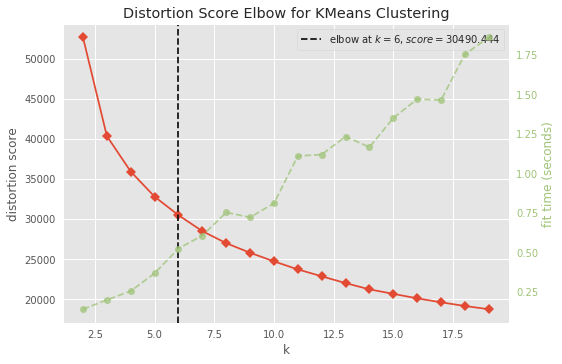

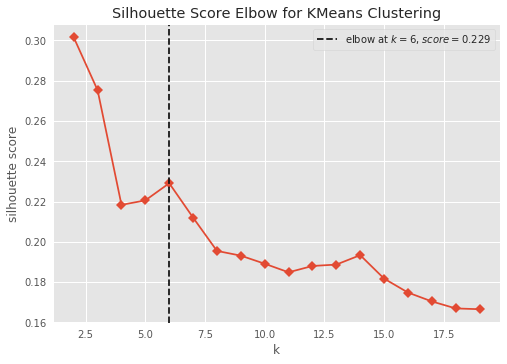

In [68]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')

visualizer_sse.fit(X_features_RP)       
visualizer_sse.show()       


visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)

visualizer.fit(X_features_RP)       
visualizer.show()

For n_clusters = 3 The average silhouette_score is : 0.27525245836831363
For n_clusters = 4 The average silhouette_score is : 0.2183328117374251
For n_clusters = 6 The average silhouette_score is : 0.2290797626331717


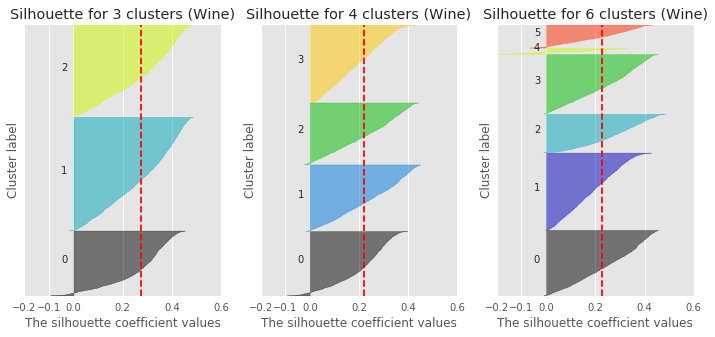

In [81]:
plot_silhouette([3,4,6], X_features_RP, 'kmeans', title='wine_rp_', dataset='Wine')       

In [70]:
kmeans_external_rp = plot_eval_external(km_models_rp, [2,3,4,7], X_features_RP, y)
            
kmeans_external_rp

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.014134,0.019506,0.016391,0.024872,0.016165
1,3,0.056910,0.041313,0.047873,0.053094,0.047556
2,4,0.064852,0.036571,0.046769,0.028961,0.046361
3,7,0.086030,0.036885,0.051633,0.024549,0.050952


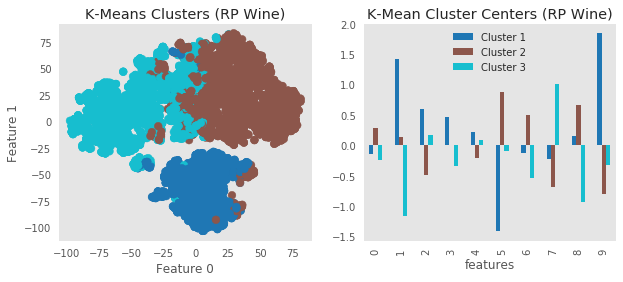

In [84]:
optimal_num_clusters = 3

optimal_kmeans_rp, optimal_kmeans_rp_centers, optimal_kmeans_rp_fit_time = optimal_kmeans_analysis(X_features_RP, 
                                                                                                   optimal_num_clusters, 
                                                                                                   save_fig=True, title='wine_rp_', dataset='RP Wine')

3.3.2 RP & EM

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


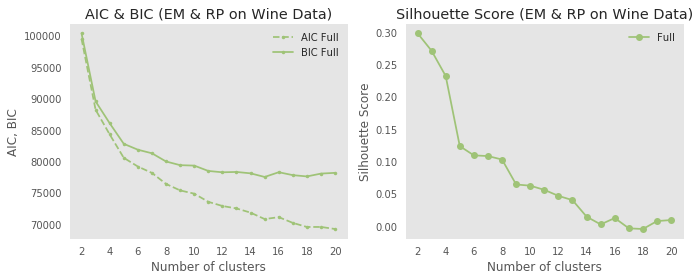

In [105]:
em_exp_full_rp, em_models_full_rp = em_iterate(k_range, X_features_RP, 'full')
em_exp_all_rp = {'Full':em_exp_full_rp}
plot_em_exp(em_exp_all_rp, 'EM & RP on Wine Data', save_fig=True, prefix='wine_rp_')

In [106]:
em_external_rp = plot_eval_external(em_models_full_rp, [2, 3, 4, 5, 6, 7, 8, 11], X_features_RP, y)          
em_external_rp

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.012586,0.017031,0.014475,0.022432,0.014251
1,3,0.017108,0.017946,0.017517,0.031245,0.017118
2,4,0.067434,0.042448,0.052101,0.061075,0.051665
3,5,0.060171,0.030715,0.040670,0.039507,0.040155
4,6,0.075070,0.035077,0.047813,0.044212,0.047211
5,7,0.098460,0.041110,0.058002,0.029930,0.057341
6,8,0.078038,0.032252,0.045641,0.025024,0.044862
7,11,0.121681,0.042120,0.062579,0.033030,0.061616


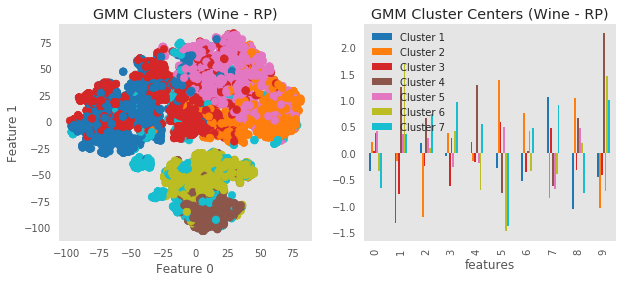

In [111]:
optimal_num_clusters_gmm = 7
optimal_gmm_rp, optimal_gmm_rp_centers, optimal_gmm_rp_fit_time = optimal_gmm_analysis(X_features_RP, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='wine_rp_', dataset='Wine - RP')

### 3.4 RF & Clustering

3.4.1 Rf & K-Means Clustering

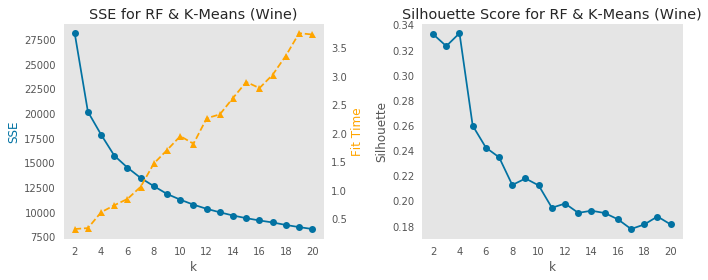

In [71]:
kmeans_exp_rf, km_models_rf = kmeans_iterate(k_range, X_features_RF)

plot_kmeans_internal_valid(kmeans_exp_rf, 'RF & K-Means', prefix='wine_RF_', dataset='(Wine)')

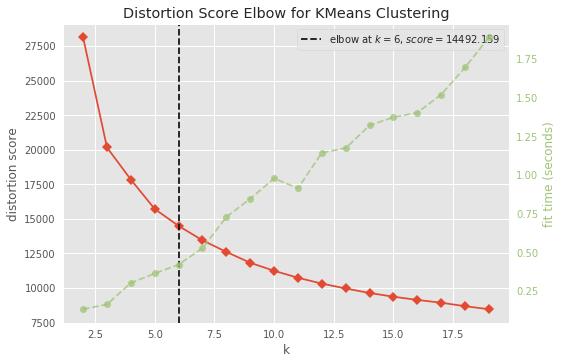

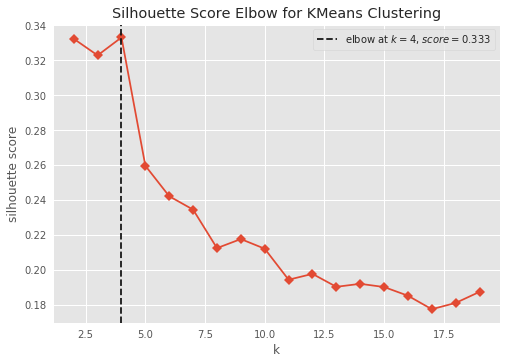

In [72]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')

visualizer_sse.fit(X_features_RF)       
visualizer_sse.show()       


visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)

visualizer.fit(X_features_RF)       
visualizer.show()

For n_clusters = 3 The average silhouette_score is : 0.32286710871515245
For n_clusters = 4 The average silhouette_score is : 0.33315893901566745
For n_clusters = 6 The average silhouette_score is : 0.2421461423996139


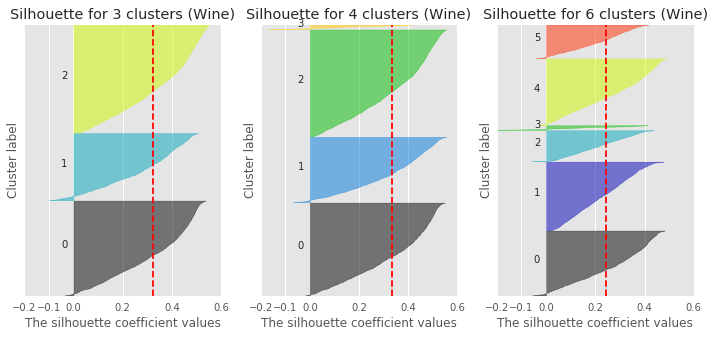

In [73]:
plot_silhouette([3,4,6], X_features_RF, 'kmeans', title='wine_rf_', dataset='Wine')            

In [74]:
kmeans_external_rf = plot_eval_external(km_models_rf, [2,3,4,6], X_features_RF, y)
            
kmeans_external_rf

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.019425,0.026235,0.022322,0.035718,0.022100
1,3,0.062506,0.045112,0.052403,0.056846,0.052089
2,4,0.065036,0.044203,0.052633,0.057582,0.052171
3,6,0.101757,0.049105,0.066243,0.046886,0.065636


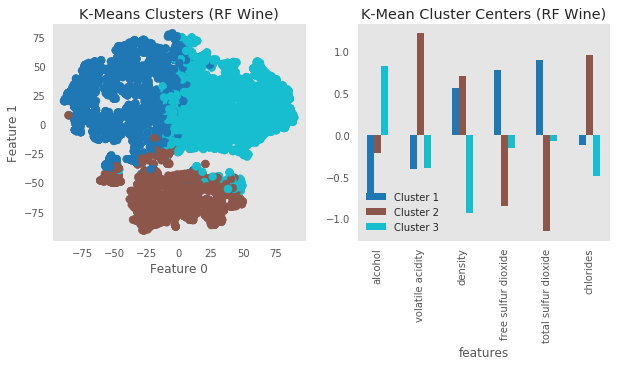

In [82]:
optimal_num_clusters = 3

optimal_kmeans_rf, optimal_kmeans_rf_centers, optimal_kmeans_rf_fit_time = optimal_kmeans_analysis(X_features_RF, 
                                                                                                   optimal_num_clusters, 
                                                                                                   save_fig=True, title='wine_rf_', dataset='RF Wine')

3.3.2 RF & EM

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


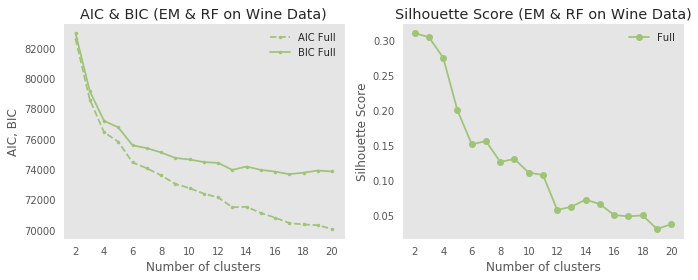

In [109]:
em_exp_full_rf, em_models_full_rf = em_iterate(k_range, X_features_RF, 'full')
em_exp_all_rf = {'Full':em_exp_full_rf}
plot_em_exp(em_exp_all_rf, 'EM & RF on Wine Data', save_fig=True, prefix='wine_rf_')

In [110]:
em_external_rf = plot_eval_external(em_models_full_rf, [2, 3, 4, 5, 6, 7, 8, 11], X_features_RF, y)          
em_external_rf

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.020982,0.026925,0.023585,0.038253,0.023368
1,3,0.024276,0.025211,0.024735,0.042878,0.024340
2,4,0.075525,0.045593,0.056861,0.060606,0.056438
3,5,0.090913,0.045242,0.060417,0.045416,0.059922
4,6,0.094523,0.043716,0.059783,0.053409,0.059192
5,7,0.102491,0.044769,0.062317,0.046126,0.061637
6,8,0.117689,0.047371,0.067552,0.045996,0.066807
7,11,0.129526,0.045429,0.067266,0.045327,0.066299


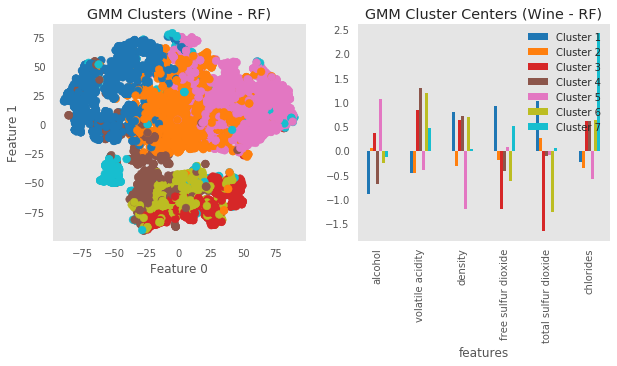

In [130]:
optimal_num_clusters_gmm = 7
optimal_gmm_rf, optimal_gmm_rf_centers, optimal_gmm_rf_fit_time = optimal_gmm_analysis(X_features_RF, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='wine_rf_', dataset='Wine - RF')

### 3.5 Comparison

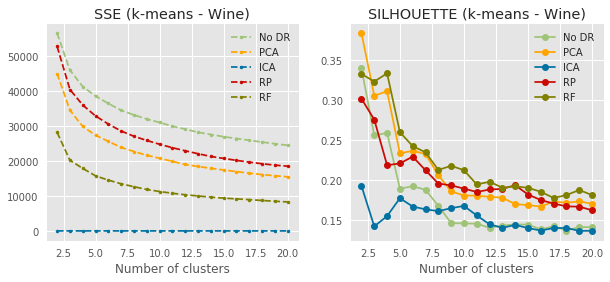

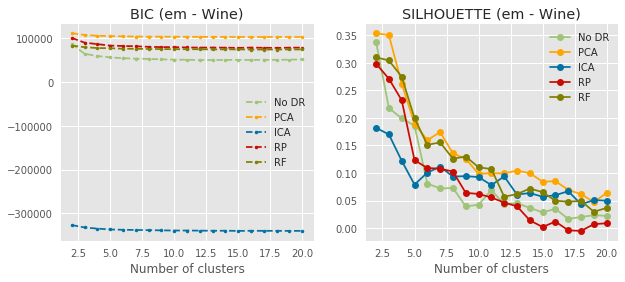

In [129]:
res_km = {'No DR': pd.DataFrame(kmeans_exp),
          'PCA':pd.DataFrame(kmeans_exp_pca),
          'ICA':pd.DataFrame(kmeans_exp_ica),
          'RP':pd.DataFrame(kmeans_exp_rp),
          'RF':pd.DataFrame(kmeans_exp_rf)}

res_em = {'No DR': pd.DataFrame(em_exp_full),
          'PCA':pd.DataFrame(em_exp_full_pca),
          'ICA':pd.DataFrame(em_exp_full_ica),
          'RP':pd.DataFrame(em_exp_full_rp),
          'RF':pd.DataFrame(em_exp_full_rf)}
def plot_cluster_comp(dict_res, model, dataset):
    colors = ['g','orange','b','r','olive']
    metric = 'sse' if model == 'k-means' else 'bic'
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    for i, k in enumerate(list(dict_res.keys())):
        ax[0].plot(dict_res[k]['k'], dict_res[k][metric], linestyle = '--', marker='.',  color=colors[i], label=k)
        ax[1].plot(dict_res[k]['k'], dict_res[k]['silhouette'], marker='o', color=colors[i], label=k )
    ax[0].set_xlabel('Number of clusters')
    ax[1].set_xlabel('Number of clusters')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title(metric.upper() + " ({} - {})".format(model, dataset))
    ax[1].set_title('silhouette'.upper() + " ({} - {})".format(model, dataset))
    plt.savefig(dataset+"_"+model+"comparison.png", dpi=100)
    plt.show()
plot_cluster_comp(res_km, 'k-means', dataset='Wine')   
plot_cluster_comp(res_em, 'em', dataset='Wine')   



### =========END========= ###